In [128]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

In [32]:
train = pd.read_csv("data/8C_train.csv", sep="\t")
valid = pd.read_csv("data/8C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [33]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

3022 train sequences
756 valid sequences


In [34]:
max_len = len(max(x_train, key=len))
print(max_len)

1500


In [35]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [36]:
cat = list(set(y_train))
cat

['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Actin binding proteins',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [37]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [38]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [39]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [40]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [41]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [42]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (3022, 1500)
x_valid shape: (756, 1500)


In [43]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [44]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

# Model 6: 1D CNN LSTM

In [49]:
max_features = tot_aa + 1
batch_size = 64

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 32
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

# Covolution layer of different size

conv1 = Conv1D(filters, 1, padding='same', activation='relu', 
              strides=1)(embedded)
pool1 = MaxPooling1D(pool_size=pool_size)(conv1)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(embedded)
pool3 = MaxPooling1D(pool_size=pool_size)(conv3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(embedded)
pool5 = MaxPooling1D(pool_size=pool_size)(conv5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(embedded)
pool9 = MaxPooling1D(pool_size=pool_size)(conv9)

#conv12 = Conv1D(filters, 15, padding='same', activation='relu', 
#              strides=1)(embedded)
#pool12 = MaxPooling1D(pool_size=pool_size)(conv12)

# Concatenate the filters
concat = concatenate([pool1, pool3, pool5, pool9], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=False, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)
probabilities = Dense(8, activation='softmax')(activations)

model = Model(inputs=_input, outputs=probabilities)

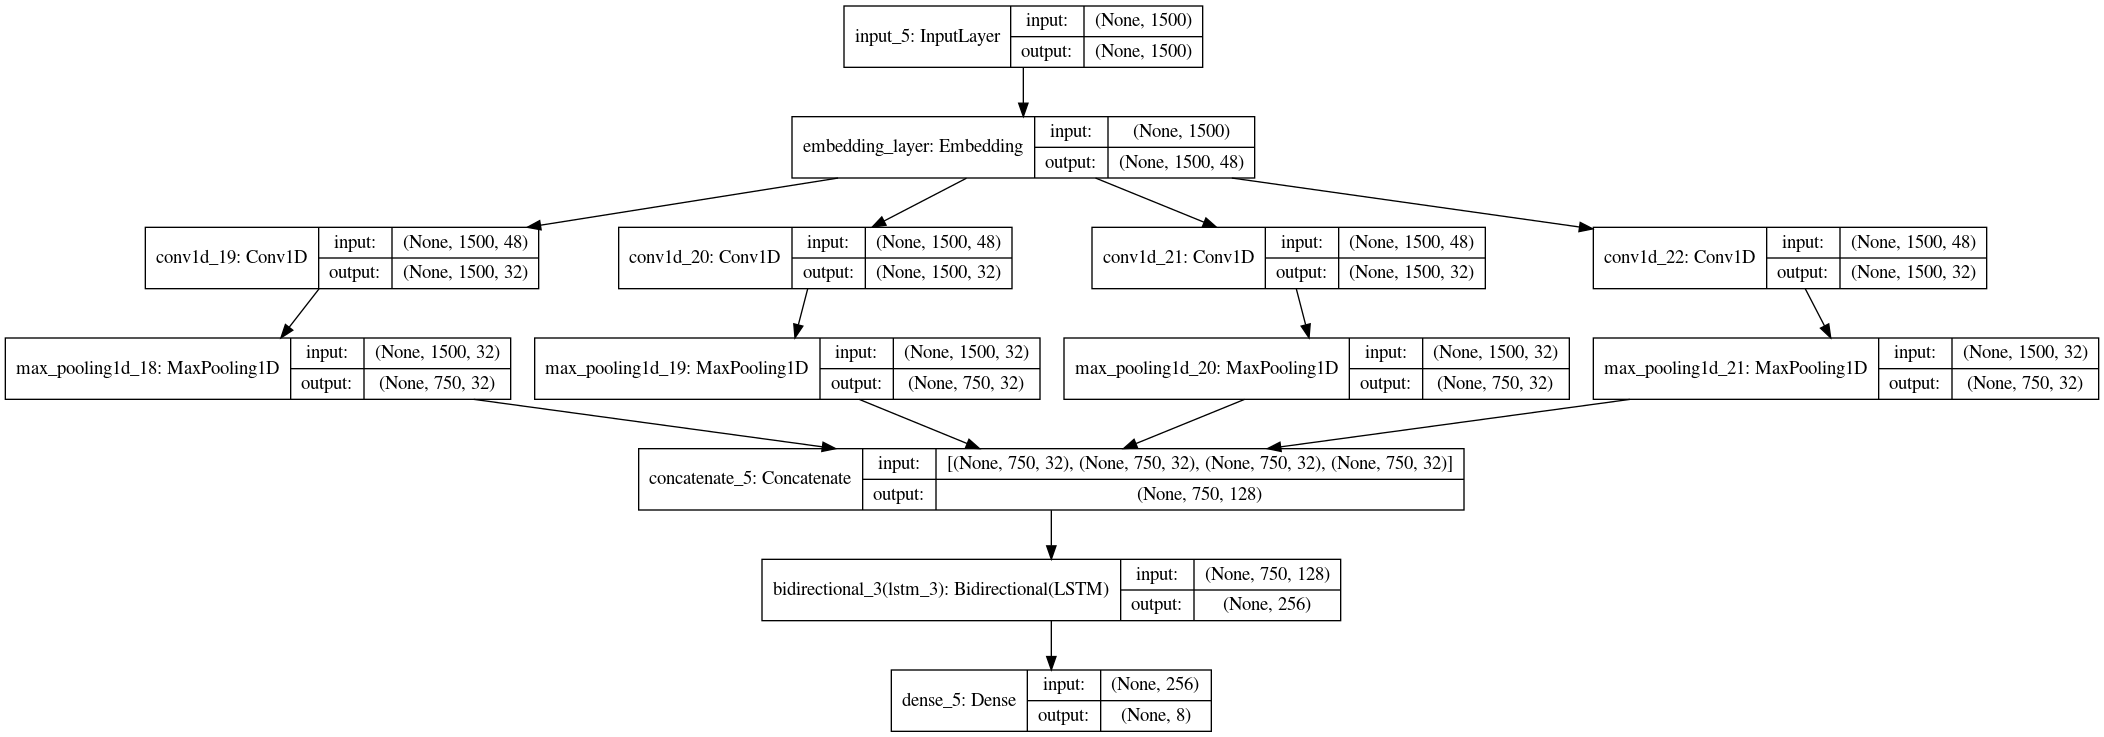

In [50]:
plot_model(model, to_file='models/model6_1DCNN_biLSTM_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model6_1DCNN_biLSTM_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=64, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3022 samples, validate on 756 samples
Epoch 1/50
3022/3022 [==============================] - 179s 59ms/step - loss: 1.5861 - accuracy: 0.5083 - val_loss: 1.5977 - val_accuracy: 0.5106

Epoch 00001: val_loss improved from inf to 1.59767, saving model to models/model6_1DCNN_biLSTM_weights.hdf5
Epoch 2/50
3022/3022 [==============================] - 172s 57ms/step - loss: 1.5328 - accuracy: 0.5099 - val_loss: 1.5778 - val_accuracy: 0.5106

Epoch 00002: val_loss improved from 1.59767 to 1.57777, saving model to models/model6_1DCNN_biLSTM_weights.hdf5
Epoch 3/50
3022/3022 [==============================] - 169s 56ms/step - loss: 1.5111 - accuracy: 0.5089 - val_loss: 1.5687 - val_accuracy: 0.5146

Epoch 00003: val_loss improved from 1.57777 to 1.56874, saving model to models/model6_1DCNN_biLSTM_weights.hdf5
Epoch 4/50
3022/3022 [==============================] - 170s 56ms/step - loss: 1.4856 - accuracy: 0.5159 - val_loss: 1.5420 - val_accuracy: 0.5119

Epoch 00004: val_loss improve


Epoch 00037: val_loss did not improve from 1.06389
Epoch 38/50
3022/3022 [==============================] - 164s 54ms/step - loss: 0.1514 - accuracy: 0.9553 - val_loss: 1.5005 - val_accuracy: 0.6852

Epoch 00038: val_loss did not improve from 1.06389
Epoch 39/50
3022/3022 [==============================] - 163s 54ms/step - loss: 0.1466 - accuracy: 0.9570 - val_loss: 1.5175 - val_accuracy: 0.6812

Epoch 00039: val_loss did not improve from 1.06389
Epoch 40/50
3022/3022 [==============================] - 163s 54ms/step - loss: 0.1348 - accuracy: 0.9633 - val_loss: 1.5444 - val_accuracy: 0.6693

Epoch 00040: val_loss did not improve from 1.06389
Epoch 41/50
3022/3022 [==============================] - 164s 54ms/step - loss: 0.1372 - accuracy: 0.9596 - val_loss: 1.5307 - val_accuracy: 0.6971

Epoch 00041: val_loss did not improve from 1.06389
Epoch 42/50
3022/3022 [==============================] - 167s 55ms/step - loss: 0.1118 - accuracy: 0.9715 - val_loss: 1.5965 - val_accuracy: 0.6984


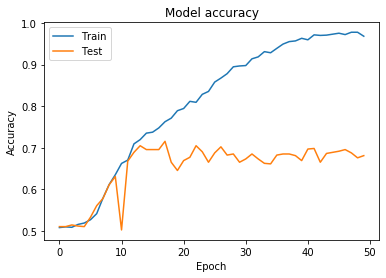

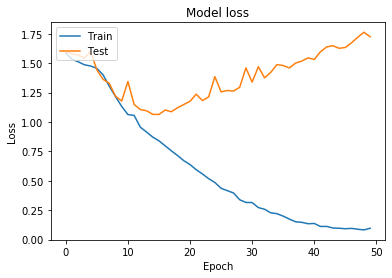

In [52]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [54]:
model = load_model('models/model6_1DCNN_biLSTM_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[1.0638910200860765, 0.6957672238349915]

In [55]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

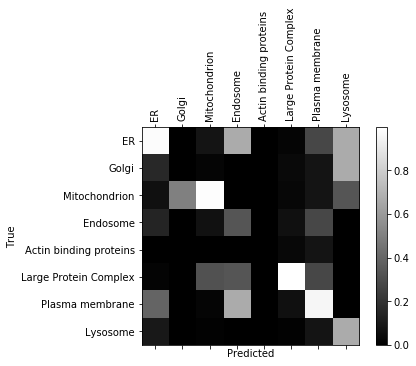

In [56]:
conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [122]:
print(conf_mx / (conf_mx.max(axis=0)+1))

[[0.98507463 0.         0.07920792 0.66666667 0.         0.01995565
  0.46153846 0.66666667]
 [0.1641791  0.75       0.01980198 0.         0.5        0.02882483
  0.09615385 0.        ]
 [0.08955224 0.         0.99009901 0.33333333 0.         0.04656319
  0.03846154 0.33333333]
 [0.14925373 0.         0.00990099 0.66666667 0.         0.07982262
  0.15384615 0.        ]
 [0.02985075 0.         0.         0.         0.         0.03104213
  0.         0.        ]
 [0.05970149 0.         0.1980198  0.         0.         0.99778271
  0.15384615 0.        ]
 [0.20895522 0.         0.00990099 0.66666667 0.         0.05986696
  0.98076923 0.33333333]
 [0.11940299 0.25       0.00990099 0.         0.         0.00665188
  0.07692308 0.        ]]


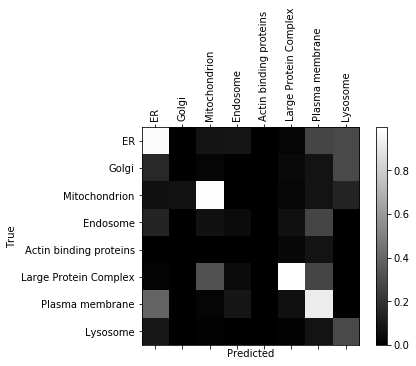

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
conf_mx

array([[ 63,   0,   7,   2,   0,   7,   7,   2],
       [ 10,   0,   2,   0,   0,  13,   2,   2],
       [  4,   1,  87,   0,   0,  10,   2,   1],
       [  9,   0,   6,   1,   0,  22,   7,   0],
       [  0,   0,   0,   0,   0,  11,   2,   0],
       [  1,   0,  28,   1,   0, 349,   7,   0],
       [ 25,   0,   2,   2,   0,  23,  24,   0],
       [  6,   0,   1,   0,   0,   3,   2,   2]])

## Model 7: CNN LSTM with normalization

With Spacial dropout to try to get more varied maps and less overfitting 

In [62]:
max_features = tot_aa + 1
batch_size = 64

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 40
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Covolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
#pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
#pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
#pool5 = MaxPooling1D(pool_size=pool_size)(conv5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
#pool9 = MaxPooling1D(pool_size=pool_size)(conv9)

conv12 = Conv1D(filters, 15, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
#pool12 = MaxPooling1D(pool_size=pool_size)(conv12)

# Concatenate the filters
concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
#concat = concatenate([pool2, pool3, pool5, pool9, pool12], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(8, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

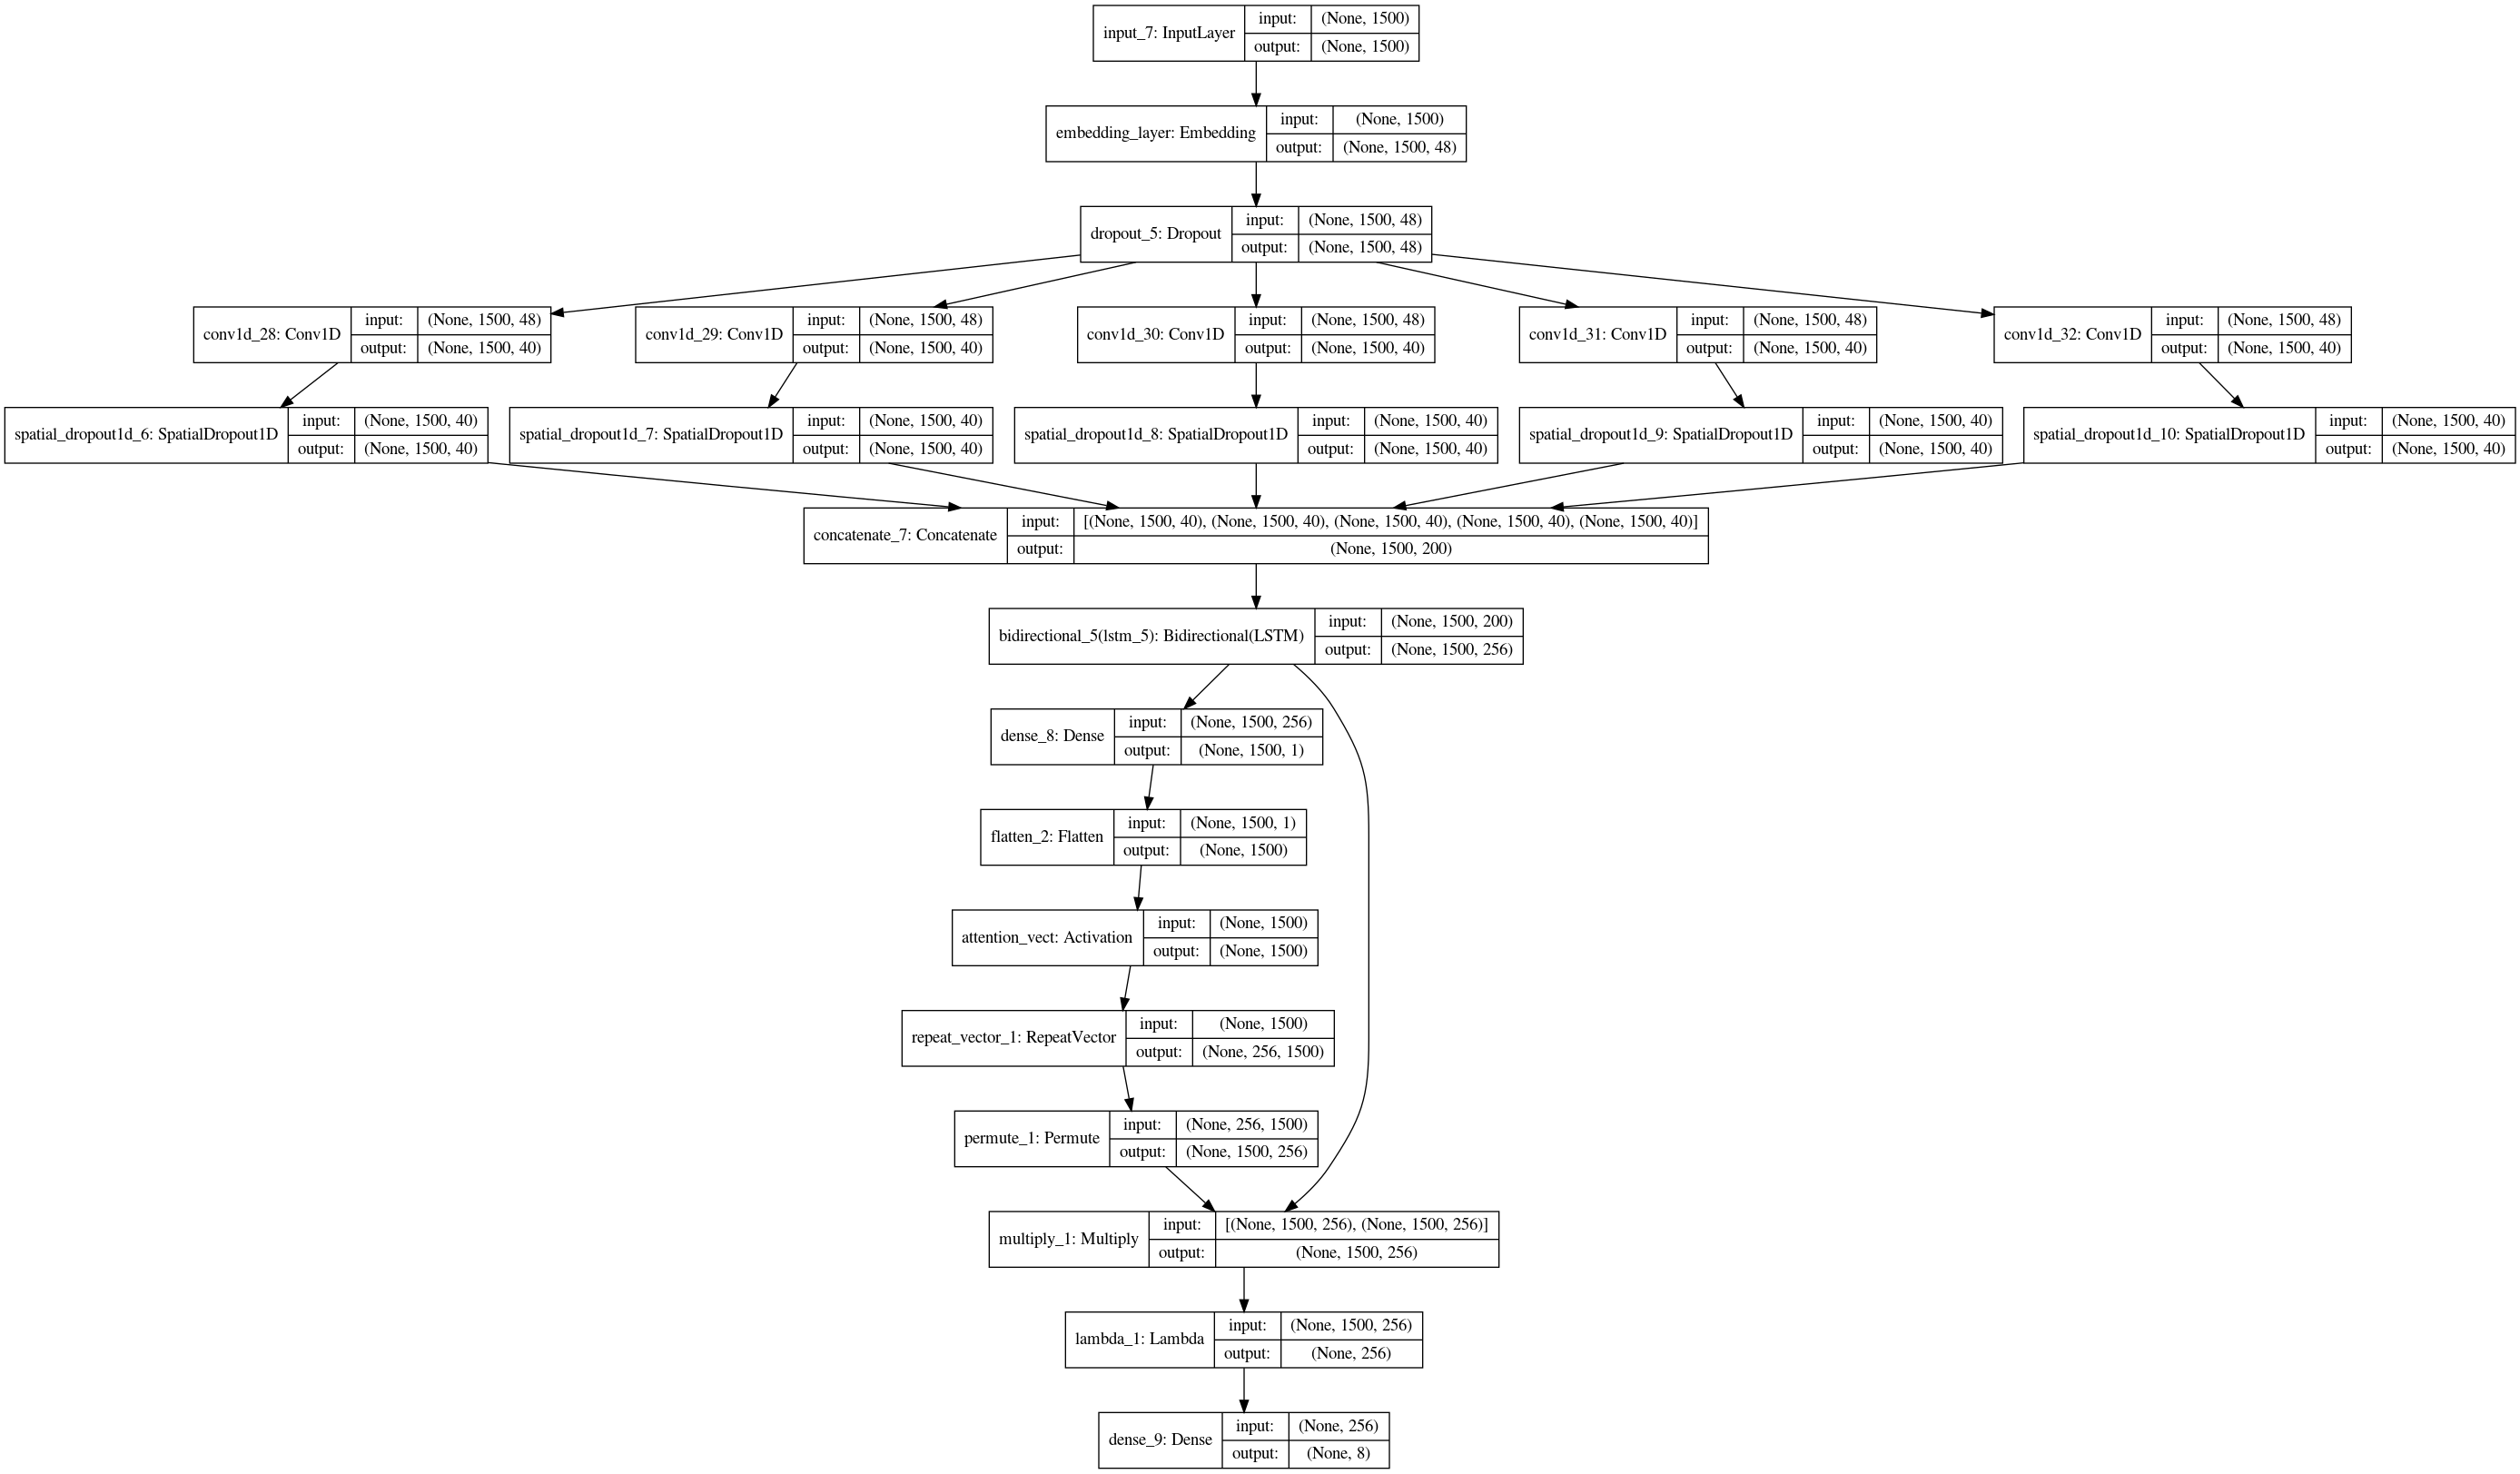

In [63]:
plot_model(model, to_file='models/model7_1DCNN_biLSTM_attention_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model7_1DCNN_biLSTM_attention_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=40,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3022 samples, validate on 756 samples
Epoch 1/40
3022/3022 [==============================] - 515s 170ms/step - loss: 1.5388 - accuracy: 0.5083 - val_loss: 1.4839 - val_accuracy: 0.5106

Epoch 00001: val_loss improved from inf to 1.48388, saving model to models/model7_1DCNN_biLSTM_attention_weights.hdf5
Epoch 2/40
3022/3022 [==============================] - 508s 168ms/step - loss: 1.4312 - accuracy: 0.5199 - val_loss: 1.3762 - val_accuracy: 0.5437

Epoch 00002: val_loss improved from 1.48388 to 1.37620, saving model to models/model7_1DCNN_biLSTM_attention_weights.hdf5
Epoch 3/40
3022/3022 [==============================] - 500s 165ms/step - loss: 1.4691 - accuracy: 0.5238 - val_loss: 1.5050 - val_accuracy: 0.5079

Epoch 00003: val_loss did not improve from 1.37620
Epoch 4/40
3022/3022 [==============================] - 500s 165ms/step - loss: 1.4691 - accuracy: 0.5106 - val_loss: 1.4615 - val_accuracy: 0.5159

Epoch 00004: val_loss did not improve from 1.37620
Epoch 5/40
3022

In [72]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model7_1DCNN_biLSTM_attention_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=15,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3022 samples, validate on 756 samples
Epoch 1/15
3022/3022 [==============================] - 527s 174ms/step - loss: 0.8619 - accuracy: 0.7379 - val_loss: 0.9683 - val_accuracy: 0.7222

Epoch 00001: val_loss improved from inf to 0.96834, saving model to models/model7_1DCNN_biLSTM_attention_weights.hdf5
Epoch 2/15
3022/3022 [==============================] - 668s 221ms/step - loss: 0.8583 - accuracy: 0.7376 - val_loss: 1.0037 - val_accuracy: 0.7116

Epoch 00002: val_loss did not improve from 0.96834
Epoch 3/15
3022/3022 [==============================] - 595s 197ms/step - loss: 0.8327 - accuracy: 0.7442 - val_loss: 0.9829 - val_accuracy: 0.7183

Epoch 00003: val_loss did not improve from 0.96834
Epoch 4/15
3022/3022 [==============================] - 526s 174ms/step - loss: 0.8354 - accuracy: 0.7455 - val_loss: 0.9654 - val_accuracy: 0.7302

Epoch 00004: val_loss improved from 0.96834 to 0.96545, saving model to models/model7_1DCNN_biLSTM_attention_weights.hdf5
Epoch 5/15
3022

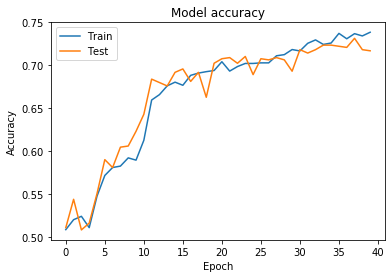

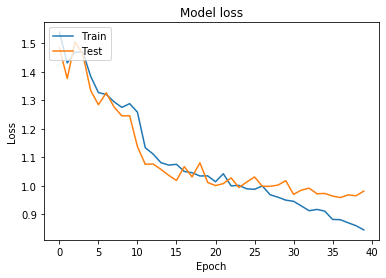

In [66]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [123]:
model = load_model('models/model7_1DCNN_biLSTM_attention_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.9654452359234845, 0.7301587462425232]

In [68]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

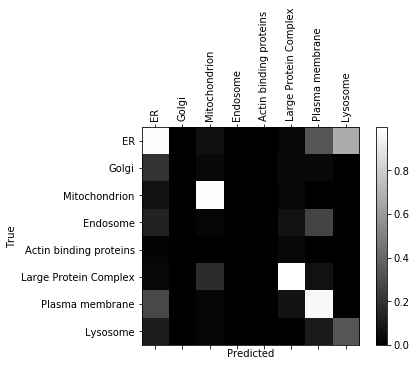

In [69]:
conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

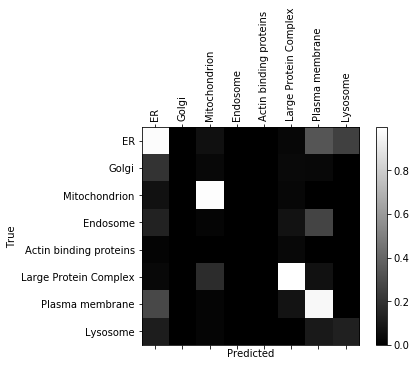

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [71]:
conf_mx

array([[ 59,   0,   6,   0,   0,  11,  10,   2],
       [ 12,   0,   3,   0,   0,  13,   1,   0],
       [  4,   0,  90,   0,   0,  11,   0,   0],
       [  8,   0,   2,   0,   0,  27,   8,   0],
       [  1,   0,   0,   0,   0,  12,   0,   0],
       [  2,   0,  16,   0,   0, 366,   2,   0],
       [ 17,   0,   2,   0,   0,  28,  29,   0],
       [  7,   0,   2,   0,   0,   1,   3,   1]])

In [76]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]

# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)

original shape:    (23, 48)
transformed shape: (23, 2)


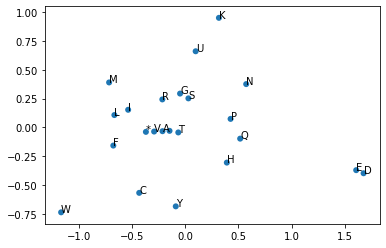

In [77]:
fig, ax = plt.subplots()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], edgecolor='none')
aaL = list(aa)
for i in range(len(aaL)):
    ax.annotate(aaL[i], (embedding_pca[:, 0][i], embedding_pca[:, 1][i]))
    
plt.show()

## Model 8

In [80]:
max_features = tot_aa + 1
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size, weights = [embedding],
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(8, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

In [81]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model8_1DCNNconv_biLSTM_attention_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3022 samples, validate on 756 samples
Epoch 1/50
3022/3022 [==============================] - 272s 90ms/step - loss: 1.4770 - accuracy: 0.5278 - val_loss: 1.6683 - val_accuracy: 0.5119

Epoch 00001: val_loss improved from inf to 1.66832, saving model to models/model8_1DCNNconv_biLSTM_attention_weights.hdf5
Epoch 2/50
3022/3022 [==============================] - 265s 88ms/step - loss: 1.3374 - accuracy: 0.5645 - val_loss: 1.2913 - val_accuracy: 0.5714

Epoch 00002: val_loss improved from 1.66832 to 1.29129, saving model to models/model8_1DCNNconv_biLSTM_attention_weights.hdf5
Epoch 3/50
3022/3022 [==============================] - 266s 88ms/step - loss: 1.2556 - accuracy: 0.6082 - val_loss: 1.1899 - val_accuracy: 0.6336

Epoch 00003: val_loss improved from 1.29129 to 1.18994, saving model to models/model8_1DCNNconv_biLSTM_attention_weights.hdf5
Epoch 4/50
3022/3022 [==============================] - 260s 86ms/step - loss: 1.1748 - accuracy: 0.6380 - val_loss: 1.0890 - val_accur


Epoch 00036: val_loss did not improve from 0.91678
Epoch 37/50
3022/3022 [==============================] - 250s 83ms/step - loss: 0.7923 - accuracy: 0.7584 - val_loss: 0.9253 - val_accuracy: 0.7381

Epoch 00037: val_loss did not improve from 0.91678
Epoch 38/50
3022/3022 [==============================] - 251s 83ms/step - loss: 0.7756 - accuracy: 0.7667 - val_loss: 0.9504 - val_accuracy: 0.7328

Epoch 00038: val_loss did not improve from 0.91678
Epoch 39/50
3022/3022 [==============================] - 254s 84ms/step - loss: 0.7643 - accuracy: 0.7664 - val_loss: 0.9404 - val_accuracy: 0.7341

Epoch 00039: val_loss did not improve from 0.91678
Epoch 40/50
3022/3022 [==============================] - 251s 83ms/step - loss: 0.7552 - accuracy: 0.7637 - val_loss: 0.9988 - val_accuracy: 0.7249

Epoch 00040: val_loss did not improve from 0.91678
Epoch 41/50
3022/3022 [==============================] - 251s 83ms/step - loss: 0.7600 - accuracy: 0.7677 - val_loss: 0.9425 - val_accuracy: 0.7368


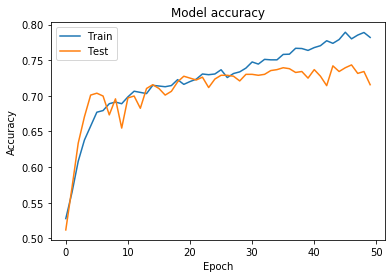

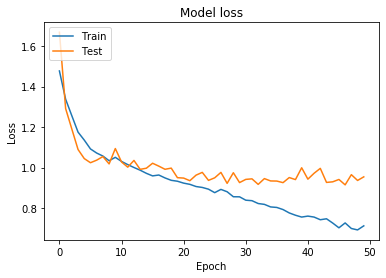

In [84]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [130]:
model = load_model('models/model8_1DCNNconv_biLSTM_attention_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.9143904088035463, 0.7433862686157227]

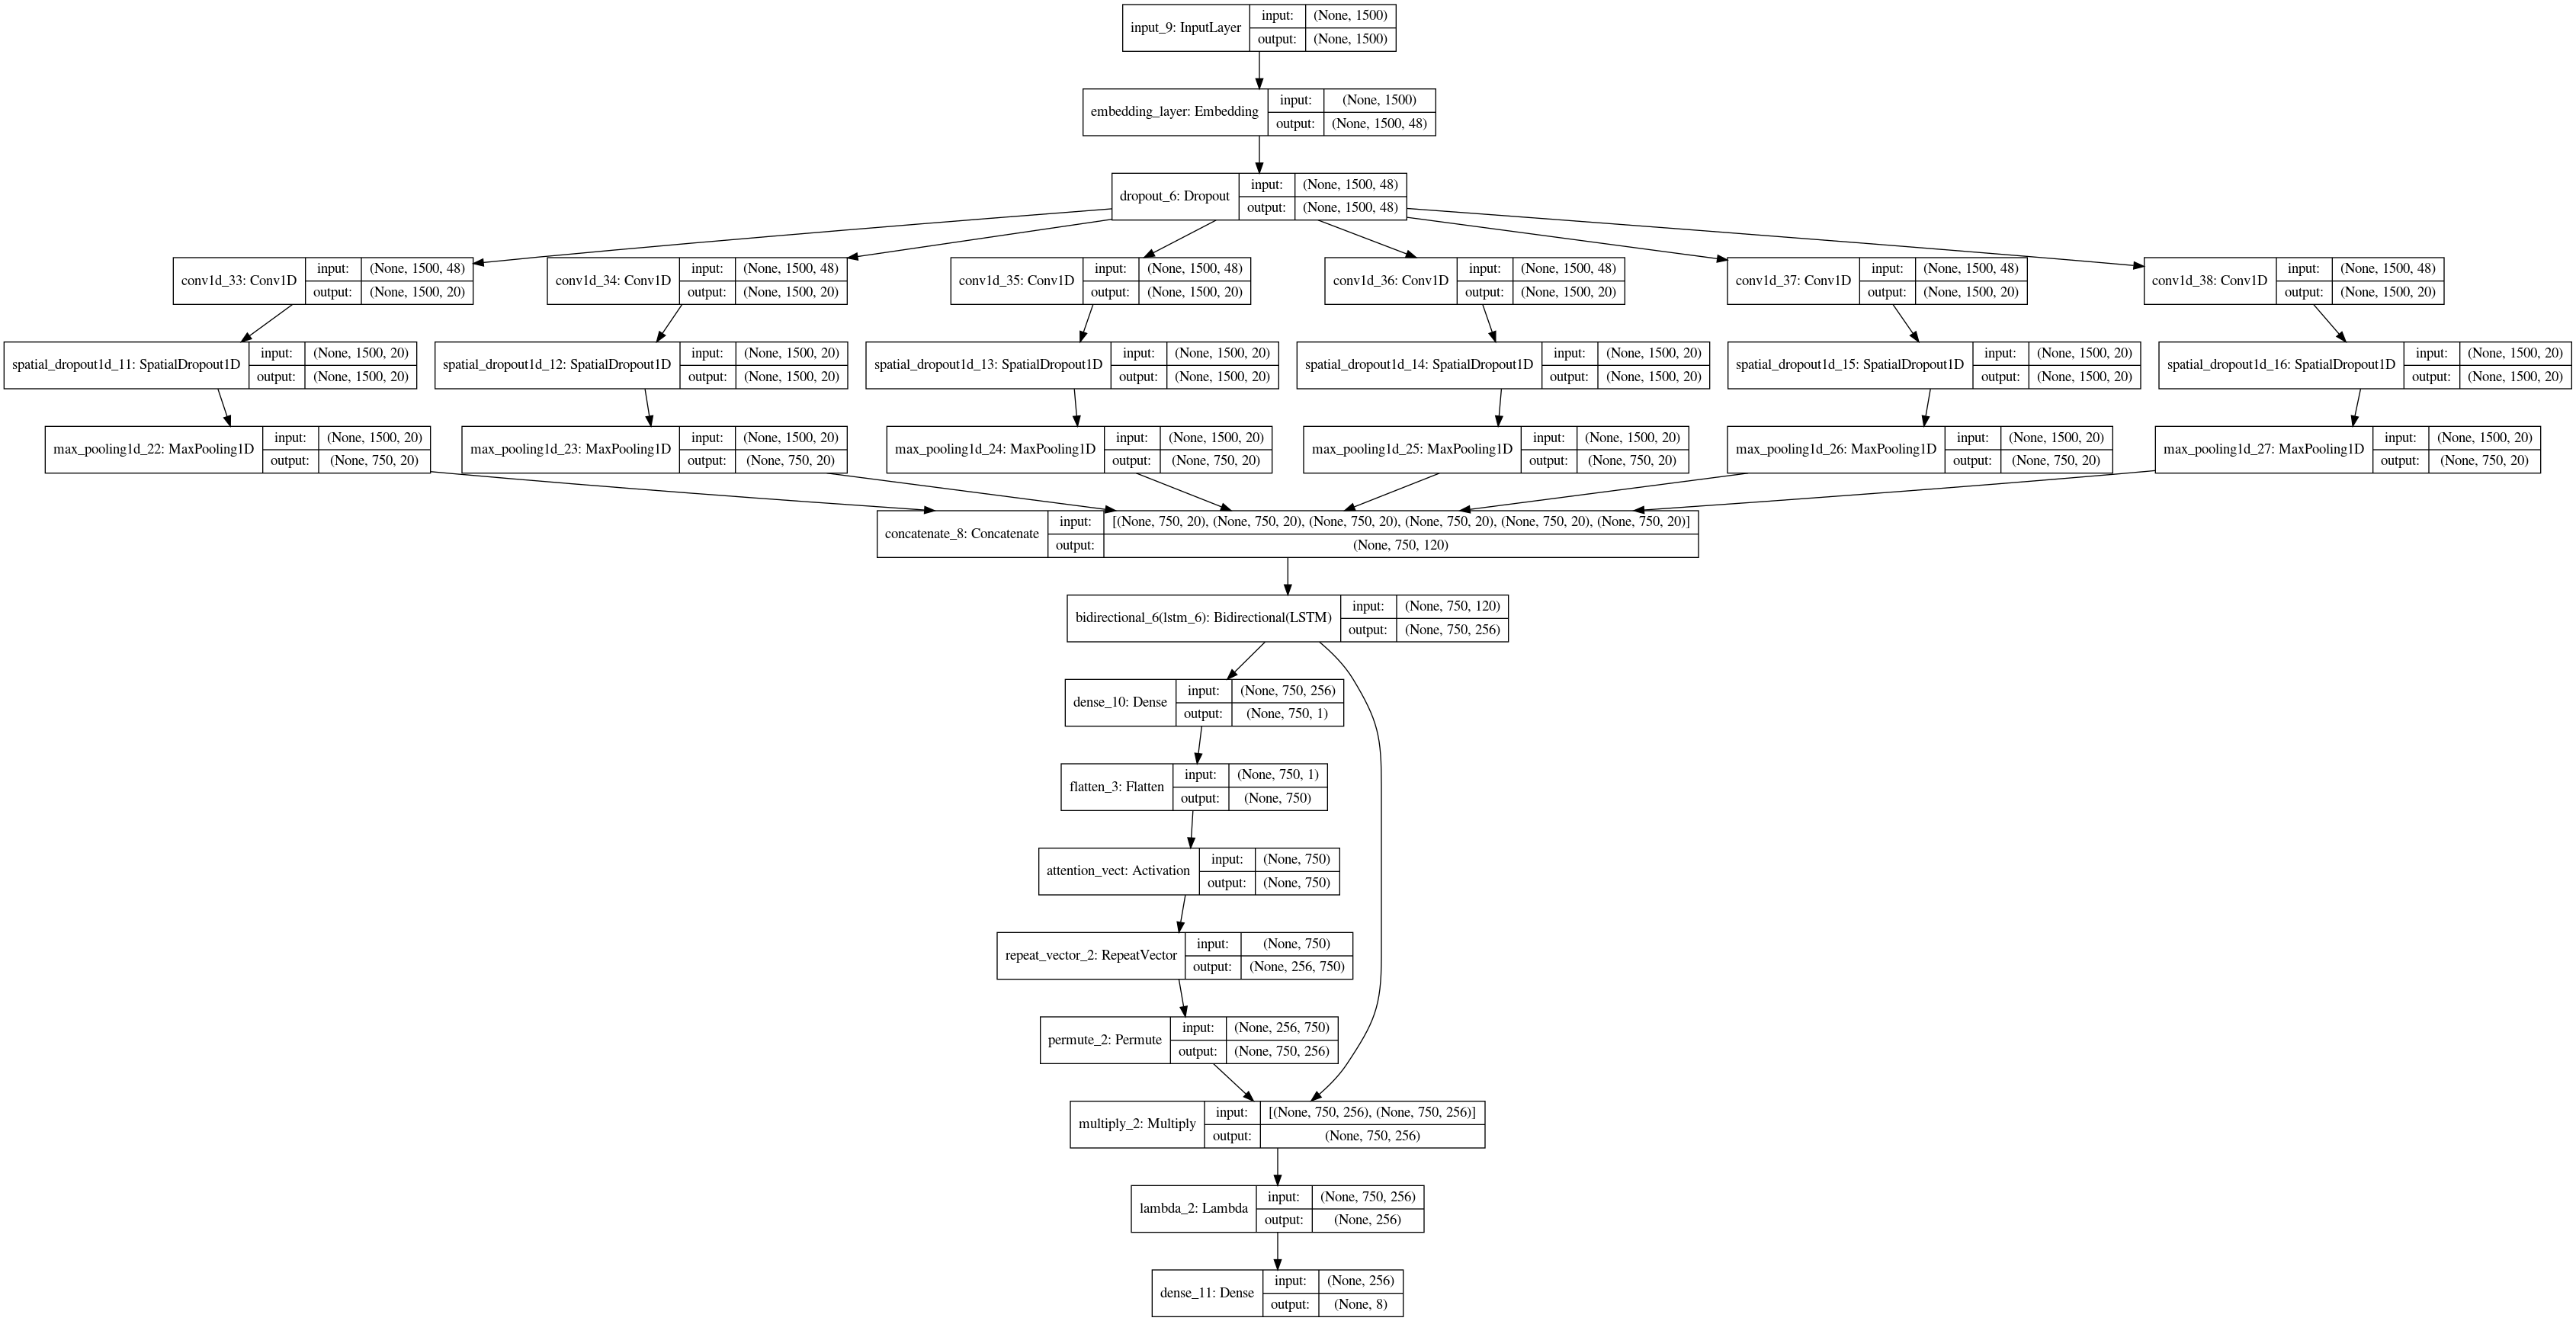

In [132]:
plot_model(model, to_file='models/model8_1DCNN_biLSTM_attention_plot.png', show_shapes=True, show_layer_names=True)

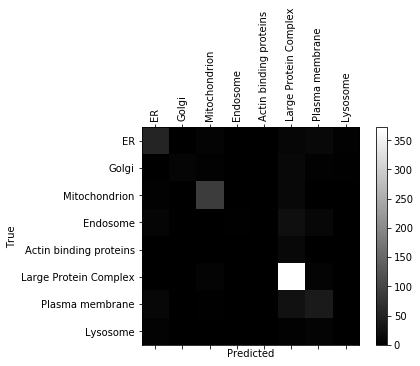

In [133]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

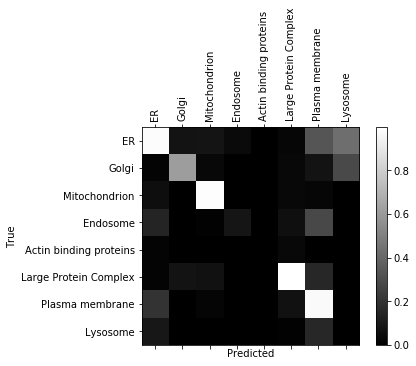

In [126]:
conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [129]:
print(classification_report(y_valid, y_pred_label))

                        precision    recall  f1-score   support

Actin binding proteins       0.00      0.00      0.00        13
                    ER       0.64      0.61      0.63        88
              Endosome       0.67      0.04      0.08        45
                 Golgi       0.80      0.28      0.41        29
 Large Protein Complex       0.79      0.96      0.87       386
              Lysosome       0.00      0.00      0.00        14
         Mitochondrion       0.82      0.84      0.83       105
       Plasma membrane       0.49      0.50      0.49        76

              accuracy                           0.74       756
             macro avg       0.53      0.40      0.41       756
          weighted avg       0.71      0.74      0.70       756



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
conf_mx

array([[ 54,   1,   7,   1,   0,   9,  13,   3],
       [  1,   8,   3,   0,   0,  12,   3,   2],
       [  3,   0,  88,   0,   0,  13,   1,   0],
       [  8,   0,   1,   2,   0,  23,  11,   0],
       [  1,   0,   0,   0,   0,  12,   0,   0],
       [  1,   1,   6,   0,   0, 372,   6,   0],
       [ 11,   0,   2,   0,   0,  25,  38,   0],
       [  5,   0,   0,   0,   0,   3,   6,   0]])

original shape:    (23, 48)
transformed shape: (23, 2)


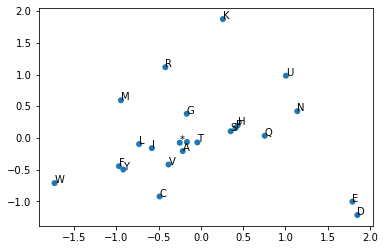

In [88]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]

# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)
fig, ax = plt.subplots()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], edgecolor='none')
aaL = list(aa)
for i in range(len(aaL)):
    ax.annotate(aaL[i], (embedding_pca[:, 0][i], embedding_pca[:, 1][i]))
    
plt.show()

## Error Analysis

In [112]:
# Add the prediction to Valid dataframe
valid["Model Prediction"] = y_pred_label

In [119]:
valid.groupby(["Compartment Prediction", "Model Prediction"]).count()/len(valid)*100

Lead Protein ID  \
Compartment Prediction Model Prediction                         
Actin binding proteins ER                            0.132275   
                       Large Protein Complex         1.587302   
ER                     ER                            7.142857   
                       Endosome                      0.132275   
                       Golgi                         0.132275   
                       Large Protein Complex         1.190476   
                       Lysosome                      0.396825   
                       Mitochondrion                 0.925926   
                       Plasma membrane               1.719577   
Endosome               ER                            1.058201   
                       Endosome                      0.264550   
                       Large Protein Complex         3.042328   
                       Mitochondrion                 0.132275   
                       Plasma membrane               1.455026   
Golgi                  ER                            0.132275   
                       Golgi                         1.058201   
                       Large Protein Complex         1.587302   
                       Lysosome                      0.264550   
                       Mitochondrion                 0.396825   
                       Plasma membrane               0.396825   
Large Protein Complex  ER                            0.132275   
                       Golgi                         0.132275   
                       Large Protein Complex        49.206349   
                       Mitochondrion                 0.793651   
                       Plasma membrane               0.793651   
Lysosome               ER                            0.661376   
                       Large Protein Complex         0.396825   
                       Plasma membrane               0.793651   
Mitochondrion          ER                            0.396825   
                       Large Protein Complex         1.719577   
                       Mitochondrion                11.640212   
                       Plasma membrane               0.132275   
Plasma membrane        ER                            1.455026   
                       Large Protein Complex         3.306878   
                       Mitochondrion                 0.264550   
                       Plasma membrane               5.026455   

                                              Prediction Confidence  \
Compartment Prediction Model Prediction                               
Actin binding proteins ER                                  0.132275   
                       Large Protein Complex               1.587302   
ER                     ER                                  7.142857   
                       Endosome                            0.132275   
                       Golgi                               0.132275   
                       Large Protein Complex               1.190476   
                       Lysosome                            0.396825   
                       Mitochondrion                       0.925926   
                       Plasma membrane                     1.719577   
Endosome               ER                                  1.058201   
                       Endosome                            0.264550   
                       Large Protein Complex               3.042328   
                       Mitochondrion                       0.132275   
                       Plasma membrane                     1.455026   
Golgi                  ER                                  0.132275   
                       Golgi                               1.058201   
                       Large Protein Complex               1.587302   
                       Lysosome                            0.264550   
                       Mitochondrion                       0.396825   
                       Plasma membrane                     0.396825   
Large Protein

In [92]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [97]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 562 correctly classified exemples
There is 194 incorrectly classified exemples
So the accuracy is: 74.33862433862434


In [114]:
corrects_df = valid[valid.index.isin(corrects)]
corrects_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
0,O43684,Large Protein Complex,Very High,MTGSNEFKLNQPPEDGISSVKFSPNTSQFLLVSSWDTSVRLYDVPA...,328,Large Protein Complex
1,P51812,Large Protein Complex,High,MPLAQLADPWQKMAVESPSDSAENGQQIMDEPMGEEEINPQTEEVS...,740,Large Protein Complex
2,Q9Y2S0,Large Protein Complex,High,MDPGSRWRNLPSGPSLKHLTDPSYGIPREQQKAALQELTRAHVESF...,1135,Large Protein Complex
4,P09234,Large Protein Complex,Very High,MPKFYCDYCDTYLTHDSPSVRKTHCSGRKHKENVKDYYQKWMEEQA...,159,Large Protein Complex
5,Q04446,Large Protein Complex,Very Low,MAAPMTPAARPEDYEAALNAALADVPELARLLEIDPYLKPYAVDFQ...,702,Large Protein Complex


In [115]:
# Now I use these list of indices to split the valid pandas dataframe
falses_df = valid[valid.index.isin(falses)]
falses_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
3,Q14442,Large Protein Complex,Very Low,MEDERSFSDICGGRLALQRRYYSPSCREFCLSCPRLSLRSLTAVTC...,188,ER
15,P82663,Mitochondrion,Medium,MPMKGRFPIRRTLQYLSQGNVVFKDSVKVMTVNYNTHGELGEGARK...,173,Large Protein Complex
16,O95302,ER,Very High,MAFRGWRPPPPPLLLLLLWVTGQAAPVAGLGSDAELQIERRFVPDE...,570,Lysosome
18,Q96Q45,Plasma membrane,Medium,MRTDSGARLEEGHLRPPRALPPVPSQDDIPLSRPKKKKPRTKNTPA...,408,ER
19,P17931,Plasma membrane,High,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...,250,Large Protein Complex


### Checking how low/very low Prediction Confidence proteins are classified

And to a certain extend, low confidence proteins are more often wrongly classified.
It make sense but it is not as bad as I was expecting.

It could make sense to remove these exemples from the dataset altogether. 

In [110]:
falses_df["Prediction Confidence"].value_counts()/ len(falses_df)*100

Medium       24.226804
Very High    24.226804
High         21.649485
Low          14.948454
Very Low     14.948454
Name: Prediction Confidence, dtype: float64

In [111]:
corrects_df["Prediction Confidence"].value_counts()/ len(corrects_df)*100

Very High    35.053381
High         29.537367
Medium       16.014235
Low          10.142349
Very Low      9.252669
Name: Prediction Confidence, dtype: float64

## Checking model on test set 

In [89]:
test = pd.read_csv("data/8C_test.csv", sep="\t")
y_test = test["Compartment Prediction"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [90]:
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

945/945 [==============================] - 21s 22ms/step
Test loss: 1.0176980343445268
Test accuracy: 0.7111111283302307


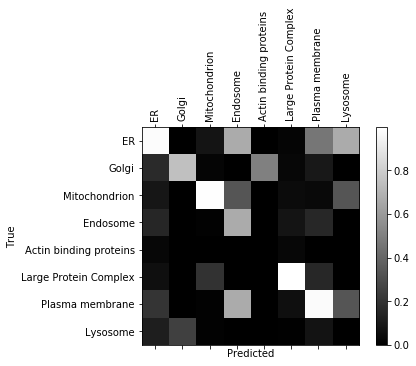

In [91]:
y_pred_test = model.predict(x_test_pad)
y_pred_indices_test = OH_to_label_indices(y_pred_test)
y_pred_label_test = indices_to_cat(y_pred_indices_test)

conf_mx = confusion_matrix(y_test, y_pred_label_test, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()